In [1]:
from Data_Class.MMSQL_connection import read_Table

df_outbound = read_Table('business_depotDEBYKN-DepotDEBYKNOrders')

df_outbound

ProgrammingError: (pyodbc.ProgrammingError) ('42000', "[42000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Cannot open server 'batsql-pp-ne-cmes-prod-10' requested by the login. Client with IP address '217.145.103.18' is not allowed to access the server.  To enable access, use the Azure Management Portal or run sp_set_firewall_rule on the master database to create a firewall rule for this IP address or address range.  It may take up to five minutes for this change to take effect. (40615) (SQLDriverConnect)")
(Background on this error at: https://sqlalche.me/e/20/f405)

In [1]:
import pandas as pd
import numpy as np
from Data_Class.MMSQL_connection import read_Table

df_outbound = read_Table('PAMS_SFG_SDDS_Outbound_Monitor')
df_outbound = df_outbound.dropna(subset=["Loading Date Plan DHL"])
df_outbound = df_outbound.dropna(subset=["Abholdatum Update"])
df_outbound = df_outbound.dropna(subset=["SCI"])
df_outbound = df_outbound[df_outbound["SCI"].str.isnumeric()]
df_outbound["Abholdatum Update"] = pd.to_datetime(df_outbound["Abholdatum Update"], errors='coerce')
df_outbound = df_outbound.rename(columns={"Abholdatum Update": "Pick-up date update"})
df_outbound["Loading Date Plan DHL"] = pd.to_datetime(df_outbound["Loading Date Plan DHL"], errors='coerce')
df_outbound["Difference in days"] = df_outbound["Pick-up date update"] - df_outbound["Loading Date Plan DHL"]
recent_data = df_outbound[df_outbound["Pick-up date update"] >= pd.Timestamp.now() - pd.Timedelta(days=20)]



data = recent_data.copy()

/var/folders/75/mgp5fc0n7t3dsv8hvb54xpy40000gn/T/ipykernel_23637/794480500.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_counts = data_clean.groupby('Pick-up date update').apply(


<Axes: xlabel='Pick-up date update'>

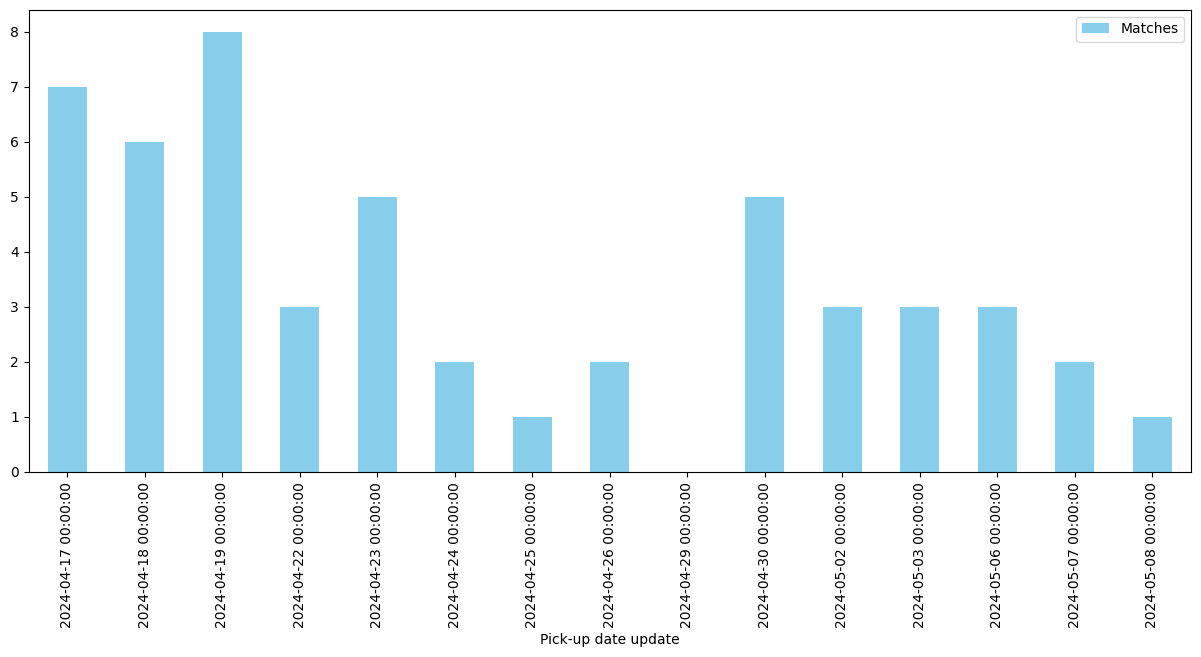

In [3]:
# Convert date columns to datetime format
data['Loading Date Plan DHL'] = pd.to_datetime(data['Loading Date Plan DHL'], errors='coerce')
data['Pick-up date update'] = pd.to_datetime(data['Pick-up date update'], errors='coerce')

# Drop rows where either date is NaT (not a time) to ensure accurate comparisons
data_clean = data.dropna(subset=['Loading Date Plan DHL', 'Pick-up date update'])

# Calculate match occurrences
match_counts = data_clean.groupby('Pick-up date update').apply(
    lambda x: (x['Loading Date Plan DHL'] == x['Pick-up date update']).sum()
).reset_index(name='Matches')

# Add total counts for better context
match_counts['Total Updates'] = data_clean.groupby('Pick-up date update').size().values

# Show results
match_counts.head(), match_counts.describe()

# show as bar chart
import matplotlib.pyplot as plt
match_counts.plot(x='Pick-up date update', y='Matches', kind='bar', figsize=(15, 6), color='skyblue')

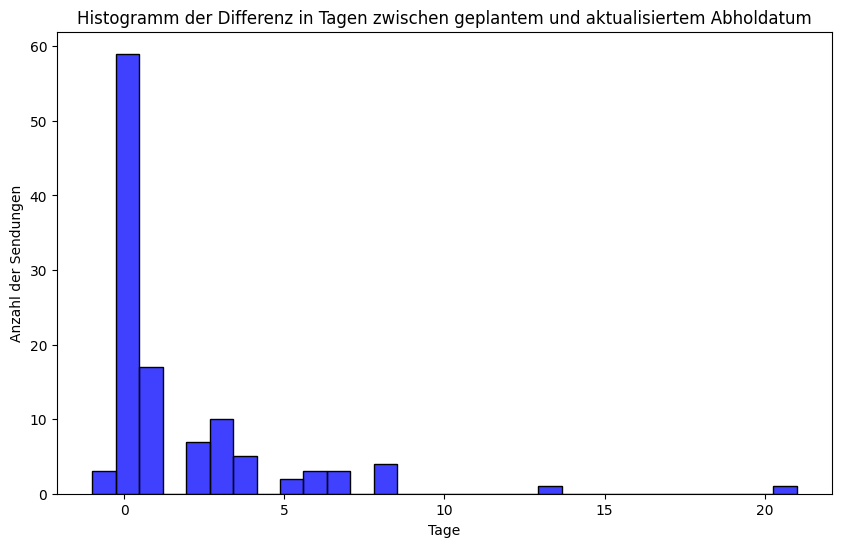

In [70]:


# Filter für die letzten 20 Tage
recent_data = df_outbound[df_outbound["Pick-up date update"] >= pd.Timestamp.now() - pd.Timedelta(days=20)]



/var/folders/75/mgp5fc0n7t3dsv8hvb54xpy40000gn/T/ipykernel_19349/444389651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Days Difference'] = recent_data['Difference in days'].dt.days


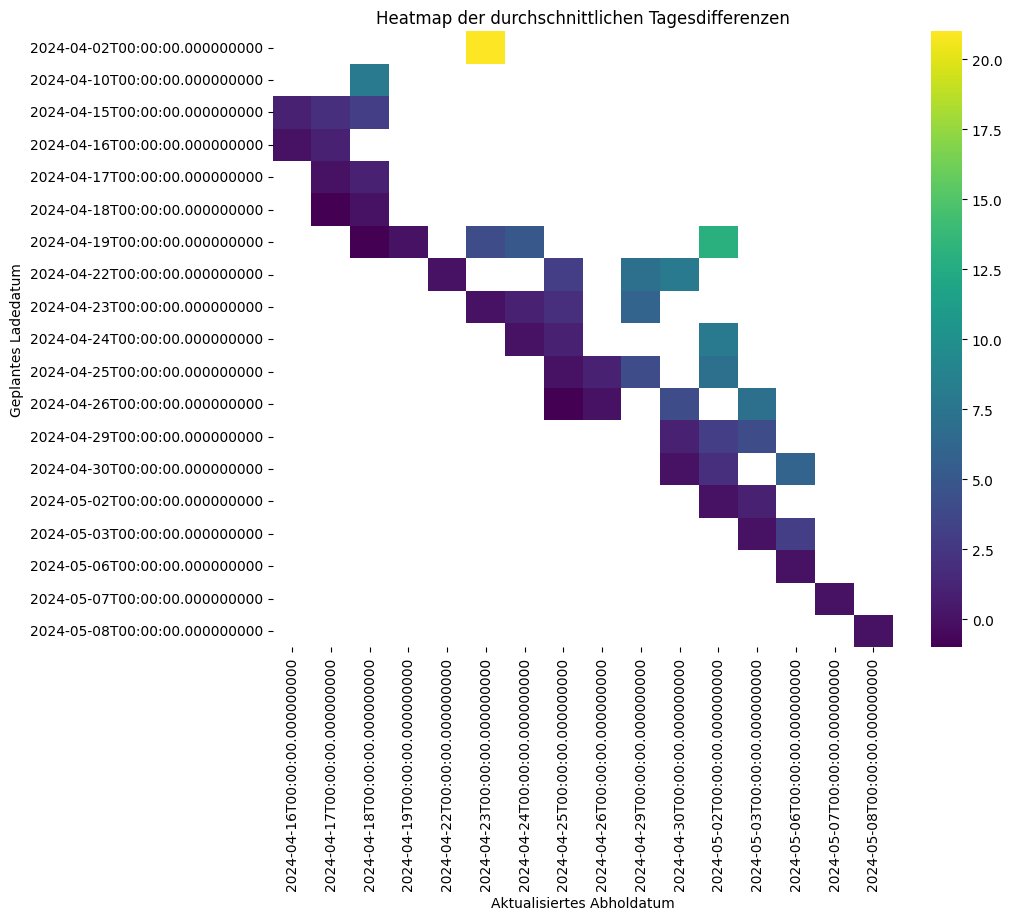

In [74]:
# Berechnung der Differenzen in ganzen Tagen
recent_data['Days Difference'] = recent_data['Difference in days'].dt.days

# Erstellung einer Pivot-Tabelle für die Heatmap
pivot_table = recent_data.pivot_table(index=pd.Grouper(key='Loading Date Plan DHL', freq='D'), columns=pd.Grouper(key='Pick-up date update', freq='D'), values='Days Difference', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Heatmap der durchschnittlichen Tagesdifferenzen')
plt.xlabel('Aktualisiertes Abholdatum')
plt.ylabel('Geplantes Ladedatum')
plt.show()


# Abweichung Ankunft zum Plandatum DIET Transporte

In [75]:
# import matplotlib.pyplot as plt

# # Konvertiere die Abweichungen in Tage
# df_outbound['Abweichung'] = df_outbound['Abweichung'].dt.days

# plt.hist(df_outbound['Abweichung'], bins=30, edgecolor='black')
# plt.title('Verteilung der Abweichungen')
# plt.xlabel('Abweichung (Tage)')
# plt.ylabel('Häufigkeit')
# plt.show()

In [76]:
import matplotlib.pyplot as plt

# Stelle sicher, dass das DataFrame sortiert ist
df_outbound = df_outbound.sort_values("Loading Date Plan DHL")

plt.figure(figsize=(10, 5))
plt.plot(df_outbound["Loading Date Plan DHL"], df_outbound["Abweichung"].dt.days, marker='o', linestyle='-')
plt.title('Zeitliche Entwicklung der Abweichungen')
plt.xlabel('Geplantes Ladedatum (DHL)')
plt.ylabel('Abweichung in Tagen')
plt.grid(True)
plt.show()


KeyError: 'Abweichung'

<Figure size 1000x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(df_outbound['Loading Date Plan DHL'], df_outbound['Abweichung'].dt.days, alpha=0.5)
plt.title('Scatter Plot der Abweichungen')
plt.xlabel('Geplantes Ladedatum (DHL)')
plt.ylabel('Abweichung in Tagen')
plt.grid(True)
plt.show()


KeyError: 'Abweichung'

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Füge eine Spalte für das Jahr hinzu
df_outbound['Jahr'] = df_outbound['Loading Date Plan DHL'].dt.year

# Erstelle eine Pivot-Tabelle
pivot_table = df_outbound.pivot_table(values='Abweichung', index='Jahr', columns='Monat', aggfunc='mean', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table.dt.days, annot=True, cmap='coolwarm', fmt=".0f")
plt.title('Heatmap der durchschnittlichen täglichen Abweichungen')
plt.xlabel('Monat')
plt.ylabel('Jahr')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'dt'

<Figure size 1200x800 with 0 Axes>